In [1]:
import sys
sys.path.append('../')
import os
import glob
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('agg' )
#%matplotlib inline
from torch.utils.data import Dataset, DataLoader

from lib.preprocessing import *
from lib.dataloading import *
from lib.loss_functions import *
from lib.evaluation import *
from torchvision import transforms
from torchvision.transforms import CenterCrop
import torchvision.models as models
from torch import optim, nn
from skimage.color import rgb2gray

In [2]:
%matplotlib inline

In [3]:
transforms = get_transformer_norm()
dataset = SSIDataset(img_file= '/home/jimmy/Data/SSI/ssi.csv', transform=transforms['val'], output_resize = True)

In [5]:
def min_max(img):
    min = np.min(img)
    max = np.max(img)
    img = (img - min)/(max-min)
    return img

In [5]:
i = random.randint(0, len(dataset))
img, center, label = dataset[i]

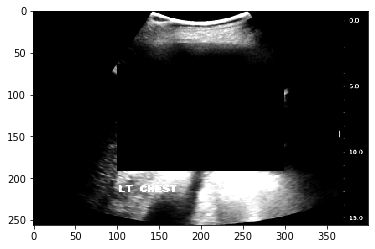

In [58]:
img = np.rollaxis(img.numpy(), 0 ,3)
img = min_max(img)                  
plt.imshow(img, cmap='gray')
plt.show()

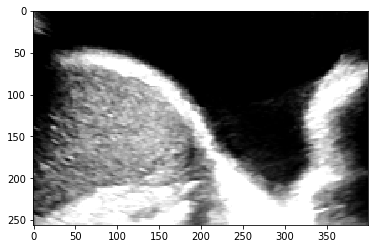

In [59]:
center = np.rollaxis(center.numpy(), 0 ,3)
center = min_max(center)                  
plt.imshow(center, cmap='gray')

(-0.5, 959.5, 721.5, -0.5)

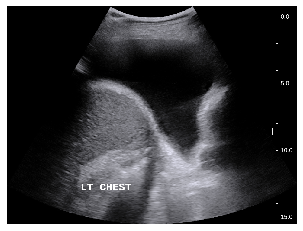

In [64]:
ori_img = original[i]
plt.imshow(ori_img, cmap='gray')
plt.axis('off')

In [69]:
w

722

(-0.5, 959.5, 721.5, -0.5)

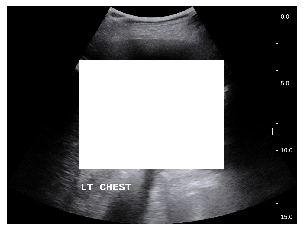

In [68]:
crop_img = ori_img.copy()
w,h = crop_img.shape[0], crop_img.shape[1]
w_offset = -30
h_offset = 60
crop_img[w//4:(w*3)//4, h//4:(h*3)//4,0] = crop_img[:, :, 0].max()            
crop_img[w//4:(w*3)//4, h//4:(h*3)//4,1] = crop_img[:, :, 1].max()            
crop_img[w//4:(w*3)//4, h//4:(h*3)//4,2] = crop_img[:, :, 2].max()            

plt.imshow(crop_img, cmap='gray')
plt.axis('off')

(-0.5, 959.5, 721.5, -0.5)

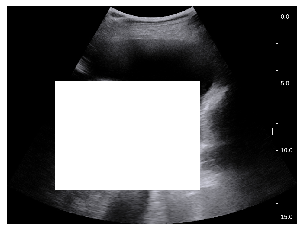

In [73]:
crop_img = ori_img.copy()
w,h = crop_img.shape[0], crop_img.shape[1]
w_offset = +70
h_offset = -80
crop_img[w_offset+w//4:w_offset+(w*3)//4, h_offset+ h//4:h_offset+ (h*3)//4,0] = crop_img[:, :, 0].max()            
crop_img[w_offset+w//4:w_offset+(w*3)//4, h_offset+ h//4:h_offset+ (h*3)//4,1] = crop_img[:, :, 1].max()            
crop_img[w_offset+w//4:w_offset+(w*3)//4, h_offset+ h//4:h_offset+ (h*3)//4,2] = crop_img[:, :, 2].max()            

plt.imshow(crop_img, cmap='gray')
plt.axis('off')

In [5]:
batch_size = 4
dataloader = torch.utils.data.DataLoader(dataset, batch_size= batch_size)
dlabel = torch.FloatTensor(batch_size)

net = CENet()     
epochs = 100
device = 'cuda:0'
net = net.to(device)
dlabel = dlabel.to(device)
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    epoch_loss = 0            

    for i, (imgs, centers, dcm_labels) in enumerate(dataloader):
        imgs, centers, dcm_labels = imgs.to(device), centers.to(device), dcm_labels.to(device)   
        break

Starting epoch 1/100.
Starting epoch 2/100.
Starting epoch 3/100.
Starting epoch 4/100.
Starting epoch 5/100.
Starting epoch 6/100.
Starting epoch 7/100.
Starting epoch 8/100.
Starting epoch 9/100.
Starting epoch 10/100.
Starting epoch 11/100.
Starting epoch 12/100.
Starting epoch 13/100.
Starting epoch 14/100.
Starting epoch 15/100.
Starting epoch 16/100.
Starting epoch 17/100.
Starting epoch 18/100.
Starting epoch 19/100.
Starting epoch 20/100.
Starting epoch 21/100.
Starting epoch 22/100.
Starting epoch 23/100.
Starting epoch 24/100.
Starting epoch 25/100.
Starting epoch 26/100.
Starting epoch 27/100.
Starting epoch 28/100.
Starting epoch 29/100.
Starting epoch 30/100.
Starting epoch 31/100.
Starting epoch 32/100.
Starting epoch 33/100.
Starting epoch 34/100.
Starting epoch 35/100.
Starting epoch 36/100.
Starting epoch 37/100.
Starting epoch 38/100.
Starting epoch 39/100.
Starting epoch 40/100.
Starting epoch 41/100.
Starting epoch 42/100.
Starting epoch 43/100.
Starting epoch 44/10

KeyboardInterrupt: 

In [6]:
from torch.nn import utils

In [22]:
class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding = 1)
        self.batchnorm = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        #self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
    

class LinearDiscriminator(nn.Module):
    def __init__(self, n_input, n_classes):
        super(LinearDiscriminator, self).__init__()
        self.n_input = n_input        
        
        self.conv1 = DiscBlock(self.n_input, 64)
        self.conv2 = DiscBlock(64,128)
        self.conv3 = DiscBlock(128,256)
        self.conv4 = DiscBlock(256,512)    
                                                
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
        self.classifier = utils.spectral_norm(nn.Linear(512, 1))
        #self.linear_project = utils.spectral_norm(nn.Embedding(n_classes, 512))
        self.linear_project = nn.Linear(512, n_classes)

    def forward(self, x, y):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)        
        
        
        x = self.avgpool(x)
        x = x.view(-1, 512)        
        
        x1 = self.classifier(x)        
                
        x2 = torch.sum(self.linear_project(x)*y, dim = 1, keepdim = True)
        #x2 = self.linear_project(y)
        
        print('x1', x1.size())
        print(x1)
        
        print('x2', x2.size())
        print(x2)
        #x2 = torch.mm(x2, x)        
        
       
        
        #x2 = torch.sum(self.linear_project(y).dot(x), dim=1, keepdim=True)
        
                
        return x1 + x2
        

In [23]:
discriminator = LinearDiscriminator(n_input=3, n_classes=9)

In [24]:
discriminator.to(device)
discriminator(centers, dcm_labels.long())

x1 torch.Size([4, 1])
tensor([[-0.8166],
        [-0.9086],
        [-0.5371],
        [-0.9656]], device='cuda:0', grad_fn=<AddmmBackward>)
x2 torch.Size([4, 1])
tensor([[ 0.1953],
        [ 0.3149],
        [ 0.0927],
        [-0.0183]], device='cuda:0', grad_fn=<SumBackward1>)


tensor([[-0.6213],
        [-0.5936],
        [-0.4445],
        [-0.9839]], device='cuda:0', grad_fn=<AddBackward0>)

In [13]:
epochs = 100
device = 'cuda:0'
net = net.to(device)
discriminator = discriminator.to(device)
dlabel = dlabel.to(device)
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    epoch_loss = 0            

    for i, (imgs, centers, dcm_labels) in enumerate(dataloader):
        imgs, centers, dcm_labels = imgs.to(device), centers.to(device), dcm_labels.to(device)                       
        # Discriminator - Train with real
        discriminator.zero_grad()
        dlabel.data.resize_(batch_size).fill_(1)
        
        break
        output = discriminator(centers)
        
        pred_dlabel = output[:,0]
        pred_dicom = output[:,1:]
        
        lossAdv_real = criteriaBCE(pred_dlabel, dlabel)        
        lossDCM = criteriaBCE(pred_dicom, dcm_labels.float())
        
                
        # Discriminator - Train with fake
        pred_centers = net(imgs)
        dlabel.data.resize_(batch_size).fill_(0)
        
        output = discriminator(pred_centers)
        pred_dlabel = output[:, 0]
        lossAdv_fake = criteriaBCE(pred_dlabel, dlabel)
        
        lossD = lossAdv_real + lossAdv_fake + lossDCM
        lossD.backward()
        optD.step()
        
        
        # Encoder
        net.zero_grad()        
        pred_centers = net(imgs)
        
        dlabel.data.resize_(batch_size).fill_(1)
        output = discriminator(pred_centers)
        pred_dlabel = output[:, 0]
        lossAdv_Encoder = criteriaBCE(pred_dlabel, dlabel)
        
        lossMSE_Encoder = criteriaMSE(pred_centers, centers)
        
        lossG = lossAdv_Encoder + lossMSE_Encoder
        lossG.backward()
        optG.step()
                                

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
              % (epoch, epochs, i, len(dataloader),
                 lossD.item(), lossG.item()))    


Starting epoch 1/100.
Starting epoch 2/100.
Starting epoch 3/100.
Starting epoch 4/100.
Starting epoch 5/100.
Starting epoch 6/100.
Starting epoch 7/100.
Starting epoch 8/100.
Starting epoch 9/100.
Starting epoch 10/100.
Starting epoch 11/100.
Starting epoch 12/100.
Starting epoch 13/100.
Starting epoch 14/100.
Starting epoch 15/100.
Starting epoch 16/100.
Starting epoch 17/100.
Starting epoch 18/100.
Starting epoch 19/100.
Starting epoch 20/100.
Starting epoch 21/100.
Starting epoch 22/100.
Starting epoch 23/100.
Starting epoch 24/100.
Starting epoch 25/100.
Starting epoch 26/100.
Starting epoch 27/100.
Starting epoch 28/100.
Starting epoch 29/100.
Starting epoch 30/100.
Starting epoch 31/100.
Starting epoch 32/100.
Starting epoch 33/100.
Starting epoch 34/100.
Starting epoch 35/100.
Starting epoch 36/100.
Starting epoch 37/100.
Starting epoch 38/100.
Starting epoch 39/100.
Starting epoch 40/100.
Starting epoch 41/100.
Starting epoch 42/100.
Starting epoch 43/100.
Starting epoch 44/10

KeyboardInterrupt: 

In [58]:
pred_dlabel

tensor([0.0009, 0.0004, 0.0004, 0.0009], device='cuda:0',
       grad_fn=<SelectBackward>)

(array([136314.,   3753.,   3609.,   2805.,   2598.,   2235.,   2292.,
          2208.,   2175.,   1926.,   2193.,   1923.,   2133.,   1800.,
          2847.,   1992.,   2769.,   3123.,   3549.,   3087.,   4377.,
          3327.,   4104.,   3771.,   4155.,   4647.,   5400.,   5133.,
          6669.,  80286.]),
 array([-0.61594206, -0.4951691 , -0.37439615, -0.25362322, -0.13285026,
        -0.0120773 ,  0.10869565,  0.2294686 ,  0.35024154,  0.4710145 ,
         0.59178746,  0.7125604 ,  0.8333334 ,  0.95410633,  1.0748793 ,
         1.1956522 ,  1.3164252 ,  1.4371982 ,  1.5579711 ,  1.6787441 ,
         1.7995169 ,  1.9202899 ,  2.0410628 ,  2.161836  ,  2.2826087 ,
         2.4033818 ,  2.5241547 ,  2.6449277 ,  2.7657006 ,  2.8864737 ,
         3.0072465 ], dtype=float32),
 <a list of 30 Patch objects>)

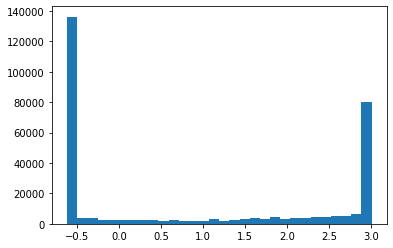

In [66]:
plt.hist(centers.cpu().detach().numpy().flatten(), bins=30)

(array([1.00000e+00, 2.00000e+00, 5.00000e+00, 8.00000e+00, 4.00000e+00,
        1.20000e+01, 1.30000e+01, 2.70000e+01, 3.20000e+01, 4.50000e+01,
        5.60000e+01, 9.50000e+01, 1.75000e+02, 2.12000e+02, 2.97000e+02,
        6.50000e+02, 1.75300e+03, 5.58600e+03, 6.52270e+04, 1.45128e+05,
        7.14340e+04, 1.31860e+04, 2.26000e+03, 6.32000e+02, 2.97000e+02,
        5.10000e+01, 4.00000e+00, 3.00000e+00, 2.00000e+00, 3.00000e+00]),
 array([-5.356752  , -5.0581355 , -4.759519  , -4.4609027 , -4.1622863 ,
        -3.8636696 , -3.5650532 , -3.2664368 , -2.9678202 , -2.6692038 ,
        -2.3705873 , -2.071971  , -1.7733544 , -1.474738  , -1.1761215 ,
        -0.87750506, -0.5788886 , -0.28027216,  0.01834431,  0.31696075,
         0.6155772 ,  0.9141937 ,  1.2128102 ,  1.5114266 ,  1.8100431 ,
         2.1086595 ,  2.407276  ,  2.7058923 ,  3.004509  ,  3.3031254 ,
         3.6017418 ], dtype=float32),
 <a list of 30 Patch objects>)

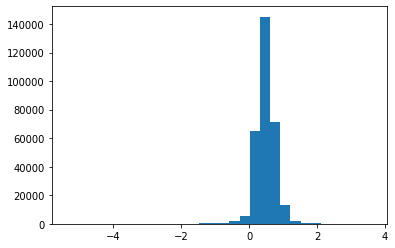

In [65]:
plt.hist(pred_centers.cpu().detach().numpy().flatten(), bins=30)

In [13]:
for img, center, label in dataloader:
    out = net(img)
    break

In [852]:
nn.MSELoss()(out, center)

tensor(2.5689, grad_fn=<MseLossBackward>)

In [857]:
disc = Discriminator(8)

In [859]:
disc(out)

tensor([[0.5451, 0.5004, 0.5394, 0.4930, 0.4963, 0.4768, 0.5000, 0.5339]],
       grad_fn=<SigmoidBackward>)

In [163]:
decode2 = DecoderBlock(256,128)
out2 = decode2(out1)
out2.size()

torch.Size([1, 128, 32, 50])

In [16]:
class CENet(nn.Module):
    def __init__(self):
        super(CENet, self).__init__()
        self.encoder = models.vgg16_bn(pretrained=False).features
        #self.fc = nn.Sequential(nn.Linear(),
        #                        nn.Linear())
        
        self.decoder = nn.Sequential(
                        # The padding size should design for different input size
                        DecoderBlock(512,256, padding=(1,0), output_padding = (1,0)),
                        DecoderBlock(256,128),
                        DecoderBlock(128,64),
                        DecoderBlock(64,32))
        
        self.conv = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.conv(x)        
        return x


In [839]:
class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding = 1)
        self.batchnorm = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        #self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super(Discriminator, self).__init__()
        self.conv1 = DiscBlock(3, 64)
        self.conv2 = DiscBlock(64,128)
        self.conv3 = DiscBlock(128,256)
        self.conv4 = DiscBlock(256,512)    
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return nn.Sigmoid()(x)

In [840]:
for img in dataloader:
    out = vgg(img)
    break

In [854]:
disc = Discriminator(6)

In [842]:
out = disc(img)

In [ ]:
disc(out)

In [843]:
out

tensor([[0.4734, 0.5003, 0.5239]], grad_fn=<SigmoidBackward>)

In [713]:
study_dict = {
    'US BIOPSY LIVER NONFOCAL':'liver',
    'US BIOPSY LIVER FOCAL': 'liver',
    'US LYMPH NODE BIOPSY': 'biopsy',
    'US BIOPSY KIDNEY NONFOCAL (EITHER SIDE)': 'kidney',
    'US PARACENTESIS THERAPEUTIC': 'paracentesis',
    'US BIOPSY TRANSPLANTED KIDNEY': 'kidney',
    'US PARACENTESIS DIAGNOSTIC AND THERAPEUTIC': 'paracentesis',
    'US THYROID BIOPSY': 'thyroid',
    'US PARACENTESIS DIAGNOSTIC': 'paracentesis',
    'US THORACENTESIS DIAGNOSTIC AND THERAPEUTIC': 'thoracentesis',
    'US THYROID ASPIRATION/FNA': 'thyroid',
    'US DRAINAGE INTERVENTION NOT OTHERWISE SPECIFIED': 'drainage',
    'US DRAINAGE ABDOMEN': 'drainage',
    'US DRAINAGE GALLBLADDER (CHOLECYSTOSTOMY)': 'liver',
    'US THORACENTESIS THERAPEUTIC (RIGHT)': 'thoracentesis',
    'US THORACENTESIS THERAPEUTIC (LEFT)': 'thoracentesis',
    'US BIOPSY MESENTERY': 'biopsy',
    'US NECK SOFT TISSUE BIOPSY': 'biopsy',
    'US DRAINAGE CATHETER PLACEMENT': 'drainage',
    'US SOFT TISSUE BIOPSY': 'biopsy',
    'US DRAINAGE PELVIS': 'drainage',
    'US BIOPSY KIDNEY NONFOCAL (LEFT)': 'kidney',
    'US CHEST TUBE PLACEMENT (RIGHT)': 'thoracentesis',
    'US BIOPSY NOT OTHERWISE SPECIFIED': 'biopsy',
    'US ABDOMINAL PELVIC BIOPSY NOT OTHERWISE SPECIFIED': 'biopsy',
    'US CHEST TUBE PLACEMENT (LEFT)': 'thoracentesis',
    'CT BIOPSY LIVER FOCAL': 'liver',
    'US BIOPSY KIDNEY FOCAL (LEFT)': 'kidney',
    'US ASPIRATION ABDOMINAL COLLECTION': 'drainage',
    'CT LYMPH NODE BIOPSY': 'biopsy',
    'US DRAINAGE LIVER': 'liver',
    'US BIOPSY RETROPERITONEUM': 'biopsy',
    'US LYMPH NODE ASPIRATION/FNA': 'drainage',
    'US SOFT TISSUE ASPIRATION': 'drainage',
    'US ASPIRATION PELVIS': 'drainage',
    'US THORACENTESIS DIAGNOSTIC (RIGHT)': 'thoracentesis',
    'US THORACENTESIS DIAGNOSTIC (LEFT)': 'thoracentesis',
    'US DRAINAGE KIDNEY/PARARENAL (RIGHT)': 'drainage',
    'US HEAD/NECK INTERVENTION NOT OTHERWISE SPECIFIED': 'biopsy',
    'US BIOPSY KIDNEY FOCAL (RIGHT)': 'kidney',
    'CT ABDOMINAL PELVIC BIOPSY NOT OTHERWISE SPECIFIED': 'biopsy',
    'US DRAINAGE KIDNEY/PARARENAL (LEFT)': 'kidney',
    'IR PARACENTESIS (THERAPEUTIC)': 'paracentesis',
    'US PSEUDOANEURYSM THROMBIN INJECTION': 'biopsy',
    'IR PARACENTESIS (DIAGNOSTIC AND THERAPEUTIC)': 'paracentesis'    
}

In [31]:
labels = [study_dict[study] for study in dataset.df.Study if study in study_dict]

In [32]:
l, c = np.unique(np.array(labels), return_counts=True)

In [39]:
dataset.df.Study.value_counts().keys()

Index(['US BIOPSY LIVER NONFOCAL', 'US BIOPSY LIVER FOCAL',
       'US LYMPH NODE BIOPSY', 'US BIOPSY KIDNEY NONFOCAL (EITHER SIDE)',
       'US PARACENTESIS THERAPEUTIC', 'US BIOPSY TRANSPLANTED KIDNEY',
       'US PARACENTESIS DIAGNOSTIC AND THERAPEUTIC', 'US THYROID BIOPSY',
       'US PARACENTESIS DIAGNOSTIC',
       'US THORACENTESIS DIAGNOSTIC AND THERAPEUTIC',
       'US THYROID ASPIRATION/FNA',
       'US DRAINAGE INTERVENTION NOT OTHERWISE SPECIFIED',
       'US DRAINAGE ABDOMEN', 'US DRAINAGE GALLBLADDER (CHOLECYSTOSTOMY)',
       'US THORACENTESIS THERAPEUTIC (RIGHT)',
       'US THORACENTESIS THERAPEUTIC (LEFT)', 'US BIOPSY MESENTERY',
       'US NECK SOFT TISSUE BIOPSY', 'US DRAINAGE CATHETER PLACEMENT',
       'US SOFT TISSUE BIOPSY', 'US DRAINAGE PELVIS',
       'US BIOPSY KIDNEY NONFOCAL (LEFT)', 'US CHEST TUBE PLACEMENT (RIGHT)',
       'US BIOPSY NOT OTHERWISE SPECIFIED',
       'US ABDOMINAL PELVIC BIOPSY NOT OTHERWISE SPECIFIED',
       'US CHEST TUBE PLACEMENT (LEF

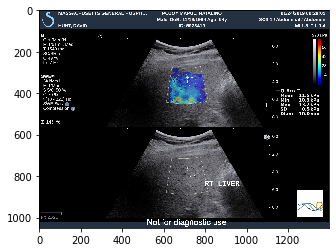

In [53]:
study = dataset.df.Study.value_counts().keys()[0]
idx = dataset.df[dataset.df.Study == study].index
i = random.choice(idx)
path = dataset.df.Image_Path.iloc[i]
ds = pydicom.dcmread(path)
plt.imshow(ds.pixel_array)

In [665]:
dataset.df.Study.value_counts()

US BIOPSY LIVER NONFOCAL                              3891
US BIOPSY LIVER FOCAL                                 1576
US LYMPH NODE BIOPSY                                   883
US BIOPSY KIDNEY NONFOCAL (EITHER SIDE)                850
US PARACENTESIS THERAPEUTIC                            844
US BIOPSY TRANSPLANTED KIDNEY                          630
US PARACENTESIS DIAGNOSTIC AND THERAPEUTIC             467
US THYROID BIOPSY                                      460
US PARACENTESIS DIAGNOSTIC                             260
US THORACENTESIS DIAGNOSTIC AND THERAPEUTIC            208
US THYROID ASPIRATION/FNA                              202
US DRAINAGE INTERVENTION NOT OTHERWISE SPECIFIED       190
US DRAINAGE ABDOMEN                                    173
US DRAINAGE GALLBLADDER (CHOLECYSTOSTOMY)              160
US THORACENTESIS THERAPEUTIC (RIGHT)                   109
US THORACENTESIS THERAPEUTIC (LEFT)                    105
US BIOPSY MESENTERY                                     